<img src="./images/impartial-logo.png" width="30%">

### Interactive deep learning whole-cell iMage segmentation and thresholding using Partial annotations

ImPartial has the potential of being expanded to other image application,
having the potential of becoming the "Snorkel" for image labeling.

* Generates high-quality single cell-annotations with minimal user-defined scribbles
* needs very few(2-3) images
* Training time is less than 5 mins
* Real-time user feedback with iterative training for best results
* Provides objective biomarker quantification
* First-ever clinical multiplex assay for T-cell lymphoma

![workflow](./images/figure1_workflow_novariance.png)


# Annotations API Demo

This demo shows the basic interactions with the ImPartial annotations API. This API **ties together inference, training and image selection** to provide the end-user with a seamless simultaneous model training and annotation 
experience, where a segmentation model learns how to segment the region of interest as the user annotates the data.


## Scenario

A specialist needs to annotate a brand new dataset that has never been used to train a model.

1. The dataset has already been loaded into the server where the API is running.
2. No scribbles have been submitted yet by the user.
3. The model needs to be trained from scratch and there are no pre-trained models available.


In [1]:
# Initialize dependencies, configurations and helper functions

import io
import base64
import requests
import numpy as np
import pickle
from PIL import Image
from skimage import measure, morphology


# MONAI Label is deployed on an EC2 instance in
# an AWS research account on a G4dn machine with 1 GPU
# monailabel_url = "http://10.0.3.62:8000"
monailabel_url = "http://localhost:8000"


def to_green(im):
    empty = Image.new("L", im.size)
    return Image.merge(
        "RGB",
        (empty, im, empty)
    )


def to_red(im):
    empty = Image.new("L", im.size)
    return Image.merge(
        "RGB",
        (im, empty, empty)
    )


def to_blue(im):
    empty = Image.new("L", im.size)
    return Image.merge(
        "RGB",
        (empty, empty, im)
    )

def b64_to_pil(b):
    return Image.open(io.BytesIO(base64.b64decode(b.encode())))


# 1. Client Initialization

Information such as available models, training configuration and dataset stats can be retrieved from this endpoint.

`GET /info`


In [ ]:
# Get Monai Label server info

res = requests.get(
    url=f"{monailabel_url}/info"
)

res.raise_for_status()

res.json()


# 2. Next Image Selection

In this step we use the active learning strategy to select an image from the unlabeled dataset. 
It could be random or it could be based on the entropy computed using the inference results.

`POST /activelearning/{strategy}`

that returns an image `id`.


In [ ]:
# Select image from dataset using random strategy

res = requests.post(
    url=f"{monailabel_url}/activelearning/random"
)

res.raise_for_status()

image_id = res.json()["id"]

print(f"Selected '{image_id}'")


Subsequently the image can be downloaded from the datastore using

`GET /datastore/image`

and passing the image `id` as parameter.

In [ ]:
# Download image from datastore

image_id = "image0"

print(f"Displaying  '{image_id}'")

res = requests.get(
    url=f"{monailabel_url}/datastore/image",
    params={"image": image_id}
)

res.raise_for_status()

image = Image.open(io.BytesIO(res.content))

display(image)


# 3. Submit Label

At this point the user will have a way of drawing over the image, and with a few scribbles label the foreground and background areas of the image.

We envision this interaction happening on the open source tool called **ImageJ** through a custom plugin that leverages this **Annotations API**.

For now, we generated some sample **scribbles off-line** to test the system. This is how they look like!

In [ ]:
%load_ext autoreload
%autoreload 2

import importlib


# Draw scribbles
import matplotlib.pyplot as plt

from dataprocessing.utils import rois_to_labels
import dataprocessing.utils as ut

importlib.reload(ut)

image_id = "image0"
print(f"Scribbles for '{image_id}'")

label_path = f"/Users/doddsr/data/DAPI1CH_zip_all/labels/final/{image_id}.zip"

scribble = ut.rois_to_labels(label_path, size=(800, 800))

foreground = Image.fromarray(scribble[..., 0] * 255)
background = Image.fromarray(scribble[..., 1] * 255)

image = image.convert("RGB")

image.paste(to_green(foreground), (0, 0), foreground)
image.paste(to_red(background), (0, 0), background)

display(image)

In [ ]:
scribbles = np.array(Image.open(scribbles_path)).astype(np.uint8)

background = np.zeros(scribbles.shape)
contours = measure.find_contours(scribbles)
for c in contours:
    c = c.astype(np.uint32)
    background[c[:, 0], c[:, 1]] = 1

background = background.astype(np.uint8)

eroded = morphology.binary_erosion(scribbles, footprint=np.ones((5, 5))).astype(np.uint8)
skeletonized = morphology.skeletonize(eroded).astype(np.uint8)
foreground_contours = np.zeros(eroded.shape)
for c in measure.find_contours(eroded):
    c = c.astype(np.uint32)
    foreground_contours[c[:, 0], c[:, 1]] = 1

foreground = skeletonized + foreground_contours.astype(np.uint8)

image = image.convert("RGB")

background = Image.fromarray(background * 255)
foreground = Image.fromarray(foreground * 255)

image.paste(to_green(foreground), (0, 0), foreground)
image.paste(to_red(background), (0, 0), background)

display(image)


Once the user is satisfied with the scribble, they can submit the label to the datastore using:

`POST /datastore/label`

with the `label` file and the `id` of the correspoding image.
This label will become available for the next training run.

In [ ]:
# Submit scribbles

print(f"Submitting label for '{image_id}'")

res = requests.put(
    url=f"{monailabel_url}/datastore/label",
    params={"image": image_id, "tag": "final"},
    files={"label": open(scribbles_path, "rb")}
)

res.raise_for_status()

res.json()


# 4. Train Model with Newly Annotated Data

Use this endpoint to start training the model with all available labels

`POST /train/{model}`

where in our case `model` would be **impartial**.

In [ ]:
# Kick-off training

res = requests.post(
    url=f"{monailabel_url}/train/impartial"
)

res.json()


In [ ]:
# Check training status

res = requests.get(
    url=f"{monailabel_url}/train"
)

res.json()

# 5. Inference

Provide feedback to the user by running inference on the training image.

`POST /infer/impartial`

The results can also provide hints to the user where more scribbles are needed.


Running inference for 'image3'


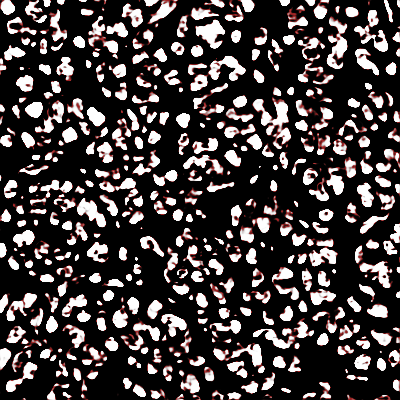

In [21]:
# Run Impartial inference
image_id = "image3"

print(f"Running inference for '{image_id}'")


res = requests.post(
    f'{monailabel_url}/infer/impartial',
    params={"image": {image_id}, "output": "json"},
)

res.raise_for_status()

im = b64_to_pil(res.json()["output"])
en = b64_to_pil(res.json()["entropy"])

im = im.convert("RGB")

im.paste(to_red(en), (0, 0), en)

display(im)

# 6. Final Results

Show an example of final results under full training cycle.